In [3]:
from utils.draw import draw_custom_weighted_graph
from ga.tsp_ga import TSPGA
from ga.tsp_ga_din_crossover import TSPGA as TSPGAC
from ga.tsp_ga_parallel import TSPGA as TSPGAP

In [4]:
from itertools import permutations
import random
from tqdm import tqdm
def generate_network(num_nodes, rand_a, rand_b):
    nodes_list = [x for x in range(num_nodes)]
    edges = list(permutations(nodes_list, 2))
    edges_w = [(*x, random.randint(rand_a,rand_b)) for x in edges]

    return nodes_list, edges_w

def evaluate_several_options(gas = [], steps_number = 100):
    steps = []
    costs_list = [[] for _ in gas]
    for step in tqdm(range(steps_number), desc="Running RA for all options"):
        for idx, ga in enumerate(gas):
            new_population, new_costs = ga.step()
            tour,cost = min(zip(new_population, new_costs), key=lambda el:el[1])
            costs_list[idx].append(cost)
        steps.append(step)
    return steps, costs_list

In [5]:
def generate_one_side_grid(params, attribute, values ):
    params_list = []
    labels = []
    for value in values:
        param = params.copy()
        param[attribute] = value
        params_list.append(param)
        labels.append(f"{attribute}:{value}")
    return params_list, labels

In [6]:
import numpy as np
from functools import reduce

def calculate_percentile(value, values):
    # Convert the input values to a numpy array
    values = np.array(values)
    
    # Calculate the percentile rank of the given value
    percentile_rank = (np.sum(values < value) / len(values) * 100)//1
    
    return percentile_rank
    
def calculate_percentiles(costs, comparing_step = 100):
    # Get the final cost for each scenario (the last element in each list)
    flat_costs = reduce(lambda a,b : a+b, costs)
    
    
    # Calculate the percentile rank of the given value
    percentile_rank = [calculate_percentile(cost[comparing_step], flat_costs) for cost in costs]
    
    return percentile_rank


In [7]:
import multiprocessing as mp


def evaluate_several_options_single(ga, steps_number=100):
    steps = []
    costs_list = []
    for step in tqdm(range(steps_number), desc=f"Running GA for single option", leave=False):
        new_population, new_costs = ga.step()
        tour, cost = min(zip(new_population, new_costs), key=lambda el: el[1])
        costs_list.append(cost)
        steps.append(step)
    return steps, costs_list

def evaluate_several_options_parallel(gas, steps_number=100):
    # Create a pool of workers
    with mp.Pool(mp.cpu_count()) as pool:
        # Parallelize the evaluation of all GA instances
        results = pool.starmap(evaluate_several_options_single, [(ga, steps_number) for ga in gas])

    # Unpack the results
    steps = [result[0] for result in results]  # List of step sequences for each GA
    costs_list = [result[1] for result in results]  # List of cost sequences for each GA
    return steps, costs_list

In [8]:

NUM_NODES = 40
nodes_list, edges_w = generate_network(num_nodes=NUM_NODES,rand_a=0,rand_b=200)

# Optimizing the hyp tunning using Pool

# Without pool

In [9]:
%%time


params = {
"population_prop":10, "crossover_proportion":0.7,"mutation_thd":0.2, "exploration_prob":0.2
}
params_list, labels = generate_one_side_grid(params, "population_prop", values = [x/10 for x in range(1,20)])

gas = [TSPGAC(nodes_list, edges_w, **param) for param in params_list]

steps, costs = evaluate_several_options(gas=gas, steps_number=100)

Running RA for all options: 100%|█████████████| 100/100 [00:19<00:00,  5.04it/s]

CPU times: user 19.9 s, sys: 17.7 ms, total: 19.9 s
Wall time: 19.9 s


# With pool, running different GA in different workers

In [10]:
%%time


params = {
"population_prop":10, "crossover_proportion":0.7,"mutation_thd":0.2, "exploration_prob":0.2
}
params_list, labels = generate_one_side_grid(params, "population_prop", values = [x/10 for x in range(1,20)])

gas = [TSPGAC(nodes_list, edges_w, **param) for param in params_list]

steps, costs = evaluate_several_options_parallel(gas=gas, steps_number=100)

CPU times: user 92.7 ms, sys: 128 ms, total: 221 ms
Wall time: 3.38 s


# Finding best population based on number of nodes

In [11]:
%%time

results = {}
cost_dict = {}
for NUM_NODES in [20,40,60,80]:
    print(NUM_NODES)

    nodes_list, edges_w = generate_network(num_nodes=NUM_NODES,rand_a=0,rand_b=200)
    
    params = {
    "population_prop":10, "crossover_proportion":0.7,"mutation_thd":0.2, "exploration_prob":0.2
    }
    params_list, labels = generate_one_side_grid(params, "population_prop", values = [x/10 for x in range(1,20,2)])
    
    gas = [TSPGAC(nodes_list, edges_w, **param) for param in params_list]
    
    steps, costs = evaluate_several_options_parallel(gas=gas, steps_number=100)
    results[f"testing {NUM_NODES} nodes"] = calculate_percentiles(costs, comparing_step=50)
    cost_dict[f"testing {NUM_NODES} nodes"] = costs

20


40


60


80


CPU times: user 571 ms, sys: 458 ms, total: 1.03 s
Wall time: 50.9 s


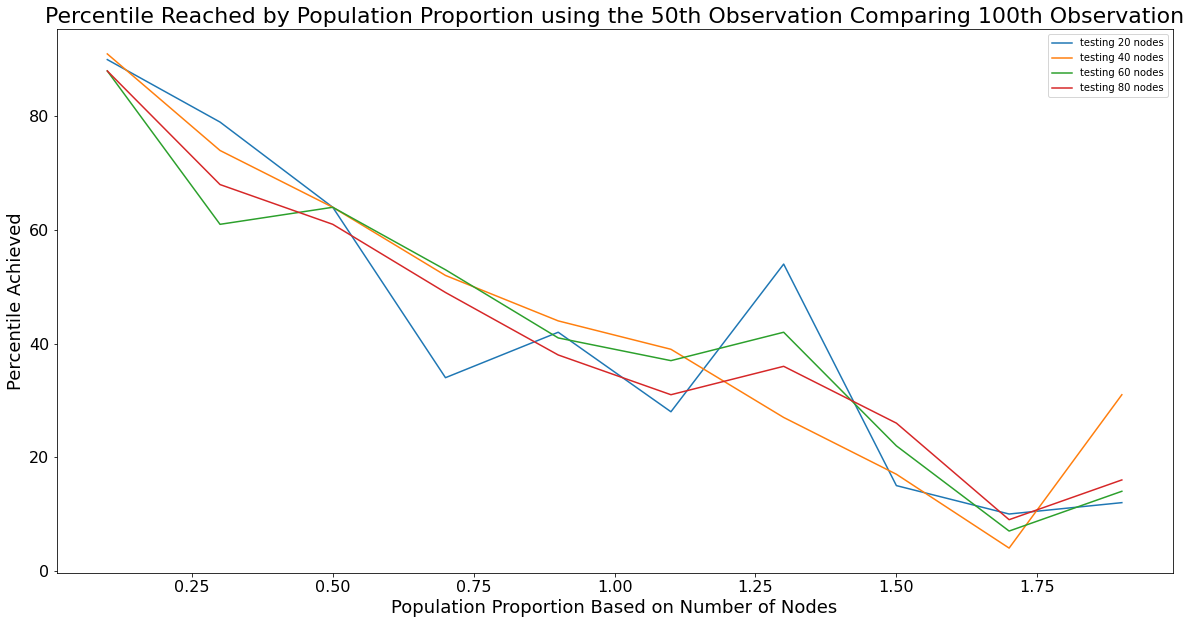

In [41]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))

# Plotting data
for idx, values in results.items():
    sns.lineplot(x=[x/10 for x in range(1, 20, 2)], y=values, label=idx)

# Adding titles and labels with larger font sizes
plt.title("Percentile Reached by Population Proportion using the 50th Observation Comparing 100th Observation", fontsize=22)
plt.xlabel("Population Proportion Based on Number of Nodes", fontsize=18)
plt.ylabel("Percentile Achieved", fontsize=18)

# Increasing the font size of the ticks on both axes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Save the plot as a PNG file
plt.savefig('imgs/population_proportion_vs_percentile.png', format='png', dpi=300)

# Display the plot
plt.show()


In [15]:
import pandas as pd
df = pd.DataFrame(data=results.values(), columns=labels)
df.index = results.keys()
avg_list = [df[fld].mean() for fld in df.columns]
df = df.T
df["AVG"] = avg_list
df

,testing 20 nodes,testing 40 nodes,testing 60 nodes,testing 80 nodes,AVG
population_prop:0.1,90.0,91.0,88.0,88.0,89.25
population_prop:0.3,79.0,74.0,61.0,68.0,70.50
population_prop:0.5,64.0,64.0,64.0,61.0,63.25
population_prop:0.7,34.0,52.0,53.0,49.0,47.00
population_prop:0.9,42.0,44.0,41.0,38.0,41.25
population_prop:1.1,28.0,39.0,37.0,31.0,33.75
population_prop:1.3,54.0,27.0,42.0,36.0,39.75
population_prop:1.5,15.0,17.0,22.0,26.0,20.00
population_prop:1.7,10.0,4.0,7.0,9.0,7.50
population_prop:1.9,12.0,31.0,14.0,16.0,18.25


In [16]:
df.to_csv("data/tunning_population_pro2.csv")

In [17]:
print(df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  testing 20 nodes &  testing 40 nodes &  testing 60 nodes &  testing 80 nodes &    AVG \\
\midrule
population\_prop:0.1 &              90.0 &              91.0 &              88.0 &              88.0 &  89.25 \\
population\_prop:0.3 &              79.0 &              74.0 &              61.0 &              68.0 &  70.50 \\
population\_prop:0.5 &              64.0 &              64.0 &              64.0 &              61.0 &  63.25 \\
population\_prop:0.7 &              34.0 &              52.0 &              53.0 &              49.0 &  47.00 \\
population\_prop:0.9 &              42.0 &              44.0 &              41.0 &              38.0 &  41.25 \\
population\_prop:1.1 &              28.0 &              39.0 &              37.0 &              31.0 &  33.75 \\
population\_prop:1.3 &              54.0 &              27.0 &              42.0 &              36.0 &  39.75 \\
population\_prop:1.5 &              15.0 &              17.0 &          

/tmp/ipykernel_58781/2350534188.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


In [29]:
result_dict = df[["AVG"]].to_dict("idx")
av, bv, cv = "population_prop:0.3", "population_prop:1.1", "population_prop:1.9"
a = result_dict[av]["AVG"]
b = result_dict[bv]["AVG"]
c = result_dict[cv]["AVG"]
a

/tmp/ipykernel_58781/3382402087.py:1: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  result_dict = df[["AVG"]].to_dict("idx")


70.5

In [30]:
print(f"Using {av} vs {bv} an improvement of: {a} - {b} = ", a - b)
print(f"Compared with {bv} vs {cv} an improvement of: {b} - {c} = ", b - c)

Using population_prop:0.3 vs population_prop:1.1 an improvement of: 70.5 - 33.75 =  36.75
Compared with population_prop:1.1 vs population_prop:1.9 an improvement of: 33.75 - 18.25 =  15.5
